# Homework 6

## Math Tools for Neural and Cognitive Science

Reuben Feinman

11/26/2017

NOTE: grader must have Python bindings for MATLAB installed. See here for details: https://www.mathworks.com/help/matlab/matlab_external/install-the-matlab-engine-for-python.html

In [1]:
from __future__ import division, print_function

import os
import numpy as np
%matplotlib inline
import matplotlib.pylab as plt

In [2]:
import matlab.engine
eng = matlab.engine.start_matlab()
eng.addpath(os.path.realpath('.'),nargout=0)

# Problem #1

In [3]:
def runGaussNoiseExpt(kernel, duration):
    """
    A wrapper function for the matlab function runGaussNoiseExpt.
    Does the necessary data type transformations to the inputs, 
    calls the matlab function, transforms the output back 
    into numpy, and returns.
    """
    kernel_mat = matlab.double(kernel.tolist())
    spikes, stimuli = eng.runGaussNoiseExpt(kernel_mat, duration, nargout=2)
    
    return np.asarray(spikes, dtype=np.bool).reshape(-1,), np.asarray(stimuli, dtype=np.float32)

## (a)

In [4]:
# define the desired kernel
kernel = np.asarray([
    [-1,-2,0],
    [-2,0,2],
    [1,2,0]
])/6.
# divide by norm
kernel /= np.linalg.norm(kernel)
# stretch it out
kernel_1d = kernel.reshape(-1,1)

In [7]:
# call the function
spikes, stimuli = runGaussNoiseExpt(kernel_1d, 100)
# compute the linear filter response to the stimuli
stimuli_responses = np.matmul(stimuli, kernel_1d)

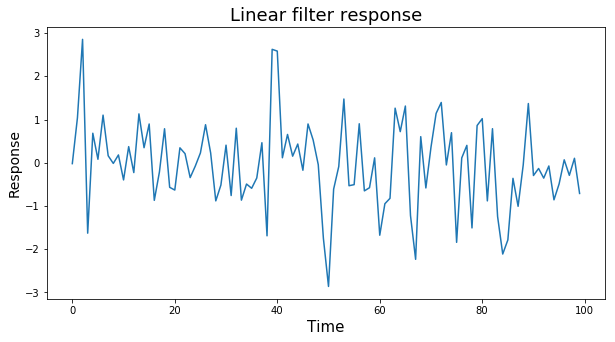

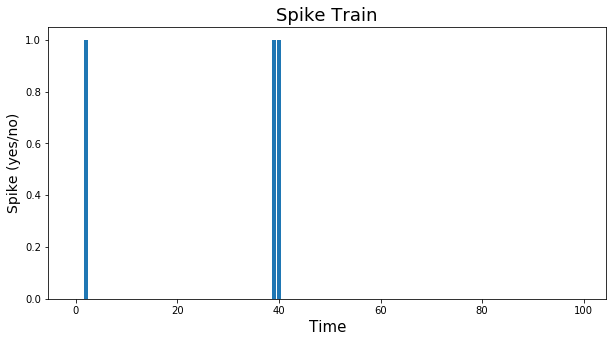

In [8]:
# Plot filter response
plt.figure(figsize=(10,5))
plt.plot(range(100),stimuli_responses)
plt.title('Linear filter response', fontsize=18)
plt.ylabel('Response', fontsize=14)
plt.xlabel('Time', fontsize=15)
plt.show()
# Plot spike train
plt.figure(figsize=(10,5))
plt.bar(range(100),spikes)
plt.title('Spike Train', fontsize=18)
plt.ylabel('Spike (yes/no)', fontsize=14)
plt.xlabel('Time', fontsize=15)
plt.show()

The spikes appear to occur at times of high response value.

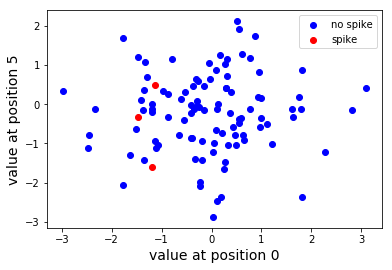

In [74]:
# Display 2D scatter plot of raw stimulus values at positions 
# 0 and 5 (translated from 1 and 6 for Python)
plt.figure()
plt.scatter(stimuli[:,0], stimuli[:,5], color='blue', label='no spike')
# get indices where spikes occured
spike_inds = np.where(spikes)[0]
plt.scatter(stimuli[spike_inds,0], stimuli[spike_inds,1], color='red', label='spike')
plt.xlabel('value at position 0', fontsize=14)
plt.ylabel('value at position 5', fontsize=14)
plt.legend()
plt.show()

In [77]:
list(enumerate(kernel_1d.reshape(-1)))

[(0, -0.23570226039551581),
 (1, -0.47140452079103162),
 (2, 0.0),
 (3, -0.47140452079103162),
 (4, 0.0),
 (5, 0.47140452079103162),
 (6, 0.23570226039551581),
 (7, 0.47140452079103162),
 (8, 0.0)]

It appears that spikes occur at negative values for position 0 and near-0 values for position 5. The results for position 0 make sense: the kernel has a negative value there. The results for position 5 are less intuitive: the kernel has a positive value there, so we'd expect to see the values be positive. It could be that the other dimensions had a greater affect on the spiking decision for these points.

## (b)

In [78]:
# Compute the sta
nb_spikes = 0
sta = np.zeros((9,))
for i in range(100):
    if spikes[i]:
        nb_spikes += 1
        sta += stimuli[i]
sta /= nb_spikes 

# rescale it to have unit norm
sta /= np.linalg.norm(sta)

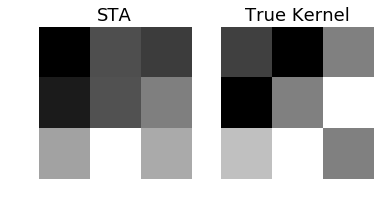

In [79]:
# Display normalized STA as a grayscale image alongside
# the ground truth kernel
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(6,3))
axes[0].imshow(sta.reshape(3,3), cmap='gray')
axes[0].set_title('STA', fontsize=18)
axes[0].axis('off')
axes[1].imshow(kernel.reshape(3,3), cmap='gray')
axes[1].set_title('True Kernel', fontsize=18)
axes[1].axis('off')
plt.show()

The STA and the true kernel look very simlar - they both have large values at bottom center and right center, and both have very small value at left center.

In [13]:
# For the STA error vs. duration experiment, I will first
# write a function to compute the normalized STA
def compute_sta(spikes, stimuli):
    nb_spikes = 0
    sta = np.zeros((9,))
    for i in range(100):
        if spikes[i]:
            nb_spikes += 1
            sta += stimuli[i]
    sta /= nb_spikes
    
    return sta

In [43]:
# Now, step through the durations and compute STAs for each,
# computing error each time
durations = np.array([100, 200, 400, 800, 1600, 3200, 6400])
# pre-allocate space for error values
errors = np.zeros_like(durations, dtype=np.float32)
variances = np.zeros_like(durations, dtype=np.float32)
for i, dur in enumerate(durations):
    sta_vals = []
    for j in range(100):
        # run the experiment
        spikes, stimuli = runGaussNoiseExpt(kernel_1d, int(dur))
        if np.where(spikes)[0].shape[0] > 0:
            # if at least one spike occured, this run should
            # contribute to our average. Compute STA...
            sta = compute_sta(spikes, stimuli)
            # sometimes we get NANs. These ruin our computation. 
            # Let's ignore them.
            if not np.isnan(sta).any():
                sta_vals.append(sta)
    sta_vals = np.asarray(sta_vals)
    sta_avg = np.mean(sta_vals, axis=0)
    sta_var = np.var(sta_vals, axis=0)
    # compute the error
    errors[i] = np.linalg.norm(sta_avg - kernel.reshape(9,), ord=1)
    variances[i] = np.mean(sta_var)
    print('duration: %i,\terror: %0.2f,\tvariance: %0.2f' % (dur, errors[i], variances[i]))

duration: 100,	error: 2.43,	variance: 0.31


/Users/reubenfeinman/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


duration: 200,	error: 2.29,	variance: 0.37
duration: 400,	error: 2.42,	variance: 0.33
duration: 800,	error: 2.64,	variance: 0.37
duration: 1600,	error: 2.52,	variance: 0.36
duration: 3200,	error: 2.45,	variance: 0.32
duration: 6400,	error: 2.44,	variance: 0.35


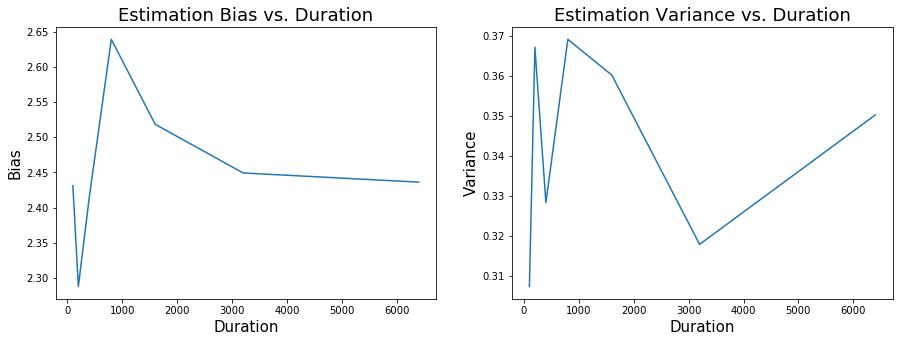

In [52]:
# plot bias and variance as function of duration
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
axes[0].plot(durations, errors)
axes[0].set_title('Estimation Bias vs. Duration', fontsize=18)
axes[0].set_xlabel('Duration', fontsize=15)
axes[0].set_ylabel('Bias', fontsize=15)
axes[1].plot(durations, variances)
axes[1].set_title('Estimation Variance vs. Duration', fontsize=18)
axes[1].set_xlabel('Duration', fontsize=15)
axes[1].set_ylabel('Variance', fontsize=15)
plt.show()

The bias and variance both seem to show a dampened oscillation. There is no clear monotonic trend in either case, although the bias seems to flatten out and reach an asymptote around 2.45.

## (c)

In [10]:
def runBinNoiseExpt(kernel, duration):
    """
    A wrapper function for the matlab function runBinNoiseExpt.
    """
    kernel_mat = matlab.double(kernel.tolist())
    spikes, stimuli = eng.runBinNoiseExpt(kernel_mat, duration, nargout=2)
    
    return np.asarray(spikes, dtype=np.bool).reshape(-1,), np.asarray(stimuli, dtype=np.float32)

In [55]:
# Now, step through the durations and compute STAs for each,
# computing error each time
durations = np.array([100, 200, 400, 800, 1600, 3200, 6400])
#durations = np.array([100, 200, 400, 800])
# pre-allocate space for error values
errors = np.zeros_like(durations, dtype=np.float32)
variances = np.zeros_like(durations, dtype=np.float32)
for i, dur in enumerate(durations):
    sta_vals = []
    for j in range(100):
        # run the experiment
        spikes, stimuli = runBinNoiseExpt(kernel_1d, int(dur))
        if np.where(spikes)[0].shape[0] > 0:
            # if at least one spike occured, this run should
            # contribute to our average. Compute STA...
            sta = compute_sta(spikes, stimuli)
            # sometimes we get NANs. These ruin our computation. 
            # Let's ignore them.
            if not np.isnan(sta).any():
                sta_vals.append(sta)
    sta_vals = np.asarray(sta_vals)
    sta_avg = np.mean(sta_vals, axis=0)
    sta_var = np.var(sta_vals, axis=0)
    # compute the error
    errors[i] = np.linalg.norm(sta_avg - kernel.reshape(9,), ord=1)
    variances[i] = np.mean(sta_var)
    print('duration: %i,\terror: %0.2f,\tvariance: %0.2f' % (dur, errors[i], variances[i]))

duration: 100,	error: 2.29,	variance: 0.23


/Users/reubenfeinman/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


duration: 200,	error: 2.41,	variance: 0.22
duration: 400,	error: 2.25,	variance: 0.21
duration: 800,	error: 2.31,	variance: 0.21
duration: 1600,	error: 2.22,	variance: 0.23
duration: 3200,	error: 2.26,	variance: 0.23
duration: 6400,	error: 2.27,	variance: 0.25


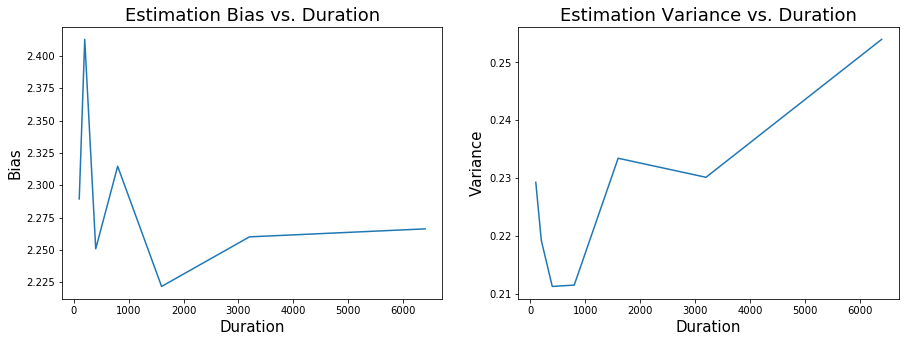

In [56]:
# plot bias and variance as function of duration
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
axes[0].plot(durations, errors)
axes[0].set_title('Estimation Bias vs. Duration', fontsize=18)
axes[0].set_xlabel('Duration', fontsize=15)
axes[0].set_ylabel('Bias', fontsize=15)
axes[1].plot(durations, variances)
axes[1].set_title('Estimation Variance vs. Duration', fontsize=18)
axes[1].set_xlabel('Duration', fontsize=15)
axes[1].set_ylabel('Variance', fontsize=15)
plt.show()

Here, the bias plot again looks like a dampened oscillation. This time, however, rather than just dampening the oscillation amplitude, the mean is also shifted downward with increased duration. This makes sense because binary noise causes bias, so we should need a higher duration to get an unbiased estimate. The variance seems to increase, generally, with greater duration here.

## (d)

In [131]:
# collect spikes and stimuli for duration=1600
spikes, stimuli = runGaussNoiseExpt(kernel_1d, 1600)
# compute sta
sta = compute_sta(spikes, stimuli)
# project stimuli onto sta
stim_proj = np.matmul(sta, stimuli.T)
# sort according to projection value
proj_sorted = sorted(enumerate(stim_proj), key= lambda x: -x[1])
spikes_p = [spikes[x[0]] for x in proj_sorted]
proj_p = [x[1] for x in proj_sorted]

In [139]:
# compute the average responses and the spike counts in each window
spike_count_avgs = np.zeros(8)
response_avgs = np.zeros(8)
for i in range(8):
    spike_count_avgs[i] = np.mean(spikes_p[200*i:200*(i+1)])
    response_avgs[i] = np.mean(proj_p[200*i:200*(i+1)])

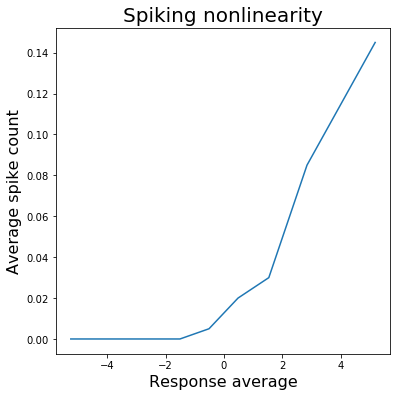

In [140]:
plt.figure(figsize=(6,6))
plt.plot(response_avgs, spike_count_avgs)
plt.title('Spiking nonlinearity', fontsize=20)
plt.xlabel('Response average', fontsize=16)
plt.ylabel('Average spike count', fontsize=16)
plt.show()

## (e)

In [155]:
# run through 100 times, drawing bootstrap samples of size
# 1600 each time
spikes_p = np.zeros((100, 1600))
proj_p = np.zeros((100, 1600))
for i in range(100):
    # draw a bootstrap sample
    ix = np.random.choice(range(1600), 1600, replace=True)
    spikes_i = spikes[ix]
    stimuli_i = stimuli[ix]
    # compute the sta
    sta = compute_sta(spikes_i, stimuli_i)
    # project stimuli onto sta
    stim_proj = np.matmul(sta, stimuli_i.T)
    # sort according to projection value
    proj_sorted = sorted(enumerate(stim_proj), key= lambda x: -x[1])
    spikes_p[i] = [spikes_i[x[0]] for x in proj_sorted]
    proj_p[i] = [x[1] for x in proj_sorted]

In [174]:
# Create bins based on 95% confidence interval of projection values
proj_mean = np.mean(proj_p)
proj_std = np.std(proj_p)
ci_lower = proj_mean - 2*proj_std
ci_upper = proj_mean + 2*proj_std
bins = np.linspace(ci_lower, ci_upper, 8)

In [179]:
# Now, step through the bootstrap samples and record spike average
# values for each of the bins. First, create dictionary where results
# will go:
results = {}
for j in range(len(bins)-1):
    results[j] = []
# Now step through the bootstrap samples
for i in range(100):
    for j in range(len(bins)-1):
        # get indices for this bin
        ix = np.where((proj_p[i] >= bins[j]) & (proj_p[i] < bins[j+1]))[0]
        # count spikes in this bin
        spike_count = np.where(spikes_p[i,ix])[0].shape[0]
        # make sure we had at least one sample in the particular bin
        # so we don't divide by 0
        if len(ix) > 0:
            results[j].append(spike_count/len(ix))

In [187]:
# compute means and std-devs for each bin
x_grid = np.array([np.mean([bins[j], bins[j+1]]) for j in range(len(bins)-1)])
means = np.array([np.mean(results[j]) for j in range(len(bins)-1)])
stds = np.array([np.std(results[j]) for j in range(len(bins)-1)])

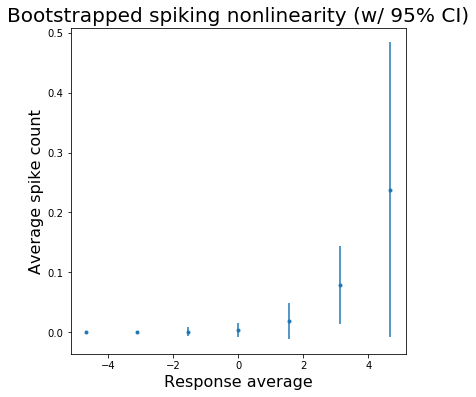

In [195]:
# plot points with errorbars
plt.figure(figsize=(6,6))
plt.errorbar(x_grid, means, yerr=2*stds, fmt='.')
plt.title('Bootstrapped spiking nonlinearity (w/ 95% CI)', fontsize=20)
plt.xlabel('Response average', fontsize=16)
plt.ylabel('Average spike count', fontsize=16)
plt.show()

# Problem #2

In [200]:
from scipy.stats import norm

## (a)

In [117]:
# Compute the two functions
i_grid = np.arange(1,11)
f1 = 0.5 + 0.5*norm.cdf(i_grid, loc=5, scale=2) # {5,2} case
f2 = 0.5 + 0.5*norm.cdf(i_grid, loc=4, scale=3) # {4,3} casee

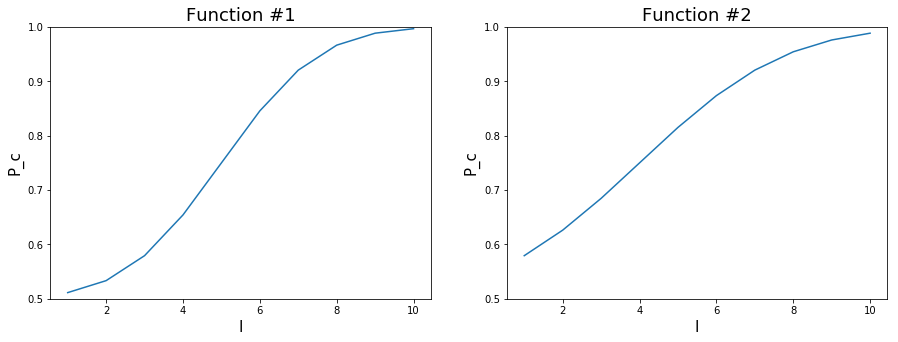

In [144]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
axes[0].plot(i_grid, f1)
axes[0].set_title('Function #1', fontsize=18)
axes[0].set_xlabel('I', fontsize=15)
axes[0].set_ylabel('P_c', fontsize=15)
axes[0].set_ylim(0.5,1)
axes[1].plot(i_grid, f2)
axes[1].set_title('Function #2', fontsize=18)
axes[1].set_xlabel('I', fontsize=15)
axes[1].set_ylabel('P_c', fontsize=15)
axes[1].set_ylim(0.5,1)
plt.show()

Function #1 appears to be less linear - it starts flat, then changes to a sharp slope, and then flattens out again. Function #2, on the other hand, has more of a constant slope.

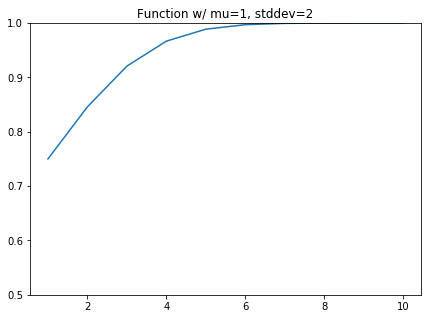

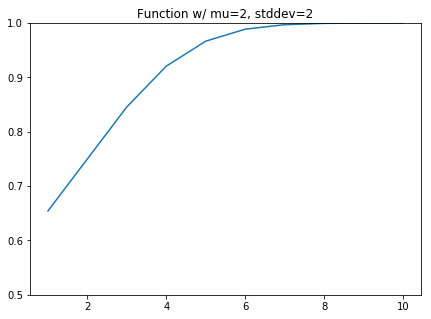

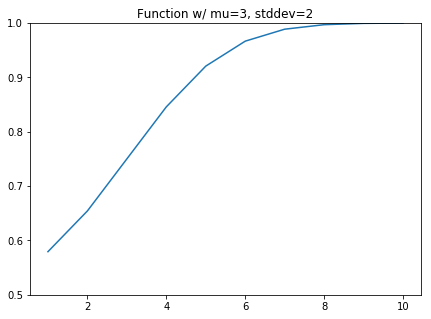

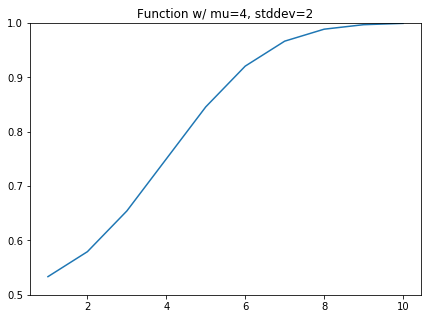

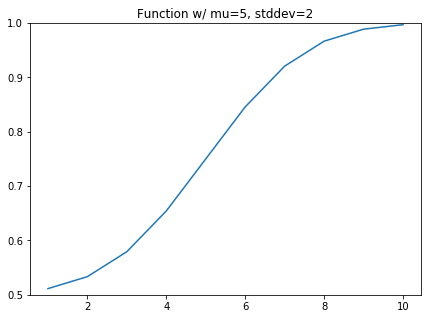

In [145]:
# Let's investigate the effect of increasing mu
for mu in range(1,6):
    plt.figure(figsize=(7,5))
    f = 0.5 + 0.5*norm.cdf(i_grid, loc=mu, scale=2)
    plt.plot(i_grid, f)
    plt.ylim(0.5, 1)
    plt.title('Function w/ mu=%i, stddev=2' % mu)
    plt.show()

By increasing mu, the curve shifts its density to the right.

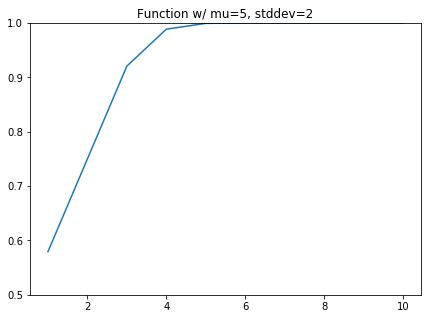

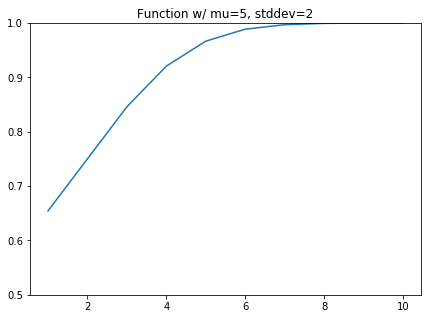

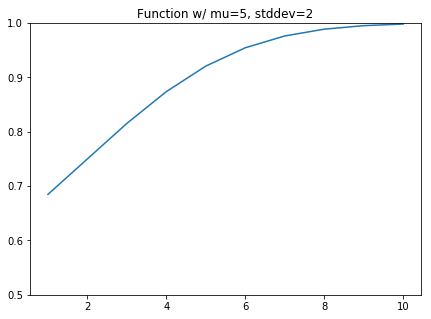

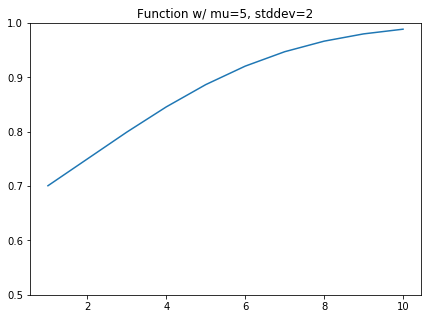

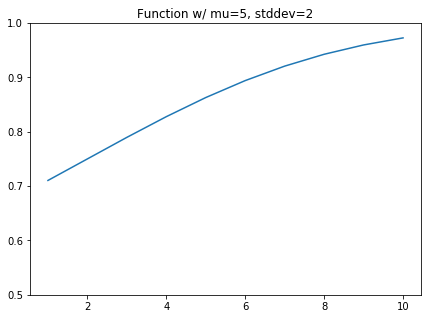

In [146]:
# Let's investigate the effect of increasing scale
for scale in range(1,6):
    plt.figure(figsize=(7,5))
    f = 0.5 + 0.5*norm.cdf(i_grid, loc=2, scale=scale)
    plt.plot(i_grid, f)
    plt.ylim(0.5, 1)
    plt.title('Function w/ mu=%i, stddev=2' % mu)
    plt.show()

By increasing std-dev, the curve flattens out from a hump to a more linear-looking function.

The range of this psychometric function is the range of intensity values for which the subject has an above-chance rate of correct responses (above 50%) but she does not always respond correctly.

## (b)

In [198]:
# Write the desired function
def simpsych(mu, sigma, I, T):
    C = []
    # step through each (i, t) pair
    for i, t in zip(I, T):
        # compute the probability for this 'i' value
        prob_correct = 0.5 + 0.5*norm.cdf(i, loc=mu, scale=sigma)
        # sample t times w/ probability 'i' of correct on each trial.
        # count the number of successes.
        nb_correct = np.random.binomial(t, prob_correct)
        C.append(nb_correct)
        
    return np.asarray(C)

## (c)

In [147]:
# Obtain the samples
T = 100*np.ones(7)
I = np.arange(1,8)
C = simpsych(4, 1, I, T)
psych_curve = 0.5 + 0.5*norm.cdf(I, loc=4, scale=1)

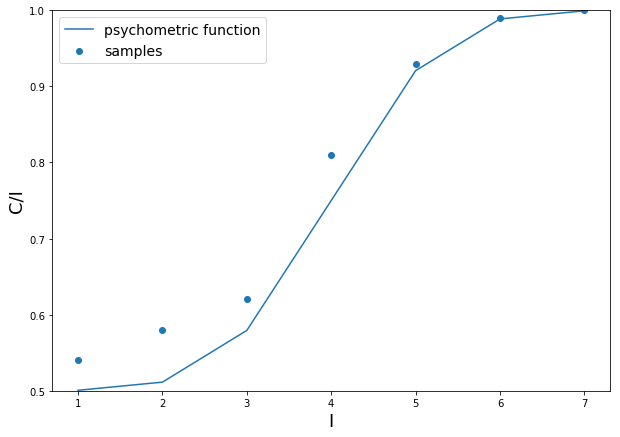

In [148]:
# Plot C/I and the psychometric function
plt.figure(figsize=(10,7))
plt.scatter(I, np.divide(C, T), label='samples')
plt.plot(I, psych_curve, label='psychometric function')
plt.ylim(0.5, 1)
plt.xlabel('I', fontsize=18)
plt.ylabel('C/I', fontsize=18)
plt.legend(fontsize=14)
plt.show()

## (d)

In [153]:
# Obtain the samples
T = 10*np.ones(7)
I = np.arange(1,8)
C = simpsych(4, 1, I, T)

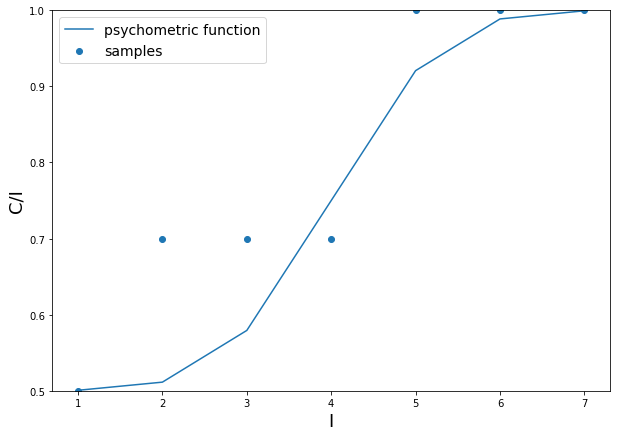

In [154]:
# Plot C/I and the psychometric function
plt.figure(figsize=(10,7))
plt.scatter(I, np.divide(C, T), label='samples')
plt.plot(I, psych_curve, label='psychometric function')
plt.ylim(0.5, 1)
plt.xlabel('I', fontsize=18)
plt.ylabel('C/I', fontsize=18)
plt.legend(fontsize=14)
plt.show()

The curve with 10 samples has a lot more variance than the curve with 100 samples; the points don't always fall near the psychometric curve (they are either above or below). This follows our expectation: as we decrease the sample size, our estimation variance should increase.

# Problem #3

## (a)

In [244]:
from scipy.stats import binom

# Write the desired function
def nloglik(mu, sigma, I, T, C):
    neg_log_likelihood = 0
    for i, t, c in zip(I, T, C):
        # compute the probability of a success for this 'i' value
        p = 0.5 + 0.5*norm.cdf(i, loc=mu, scale=sigma)
        # compute the likelihood of the observed outcome
        likelihood = binom.pmf(c, t, p)
        # add negative log likelihood to the accumulator
        neg_log_likelihood -= np.log(likelihood)
        
    return neg_log_likelihood

## (b)

In [245]:
# Obtain the dataset from part (c) of previous problem
T = 100*np.ones(7)
I = np.arange(1,8)
C = simpsych(4, 1, I, T)

# Compute negative log likelihood scores for the desired ranges
muall = np.arange(2, 10.2, 0.2)
sigmaall = np.arange(0.5, 6, 0.2)
M, S = np.meshgrid(muall, sigmaall)
L = np.zeros_like(M)
for i in range(len(sigmaall)):
    for j in range(len(muall)):
        L[i,j] = nloglik(M[i,j], S[i,j], I, T, C)

In [246]:
lmax = np.max(L)
lmin = np.min(L)

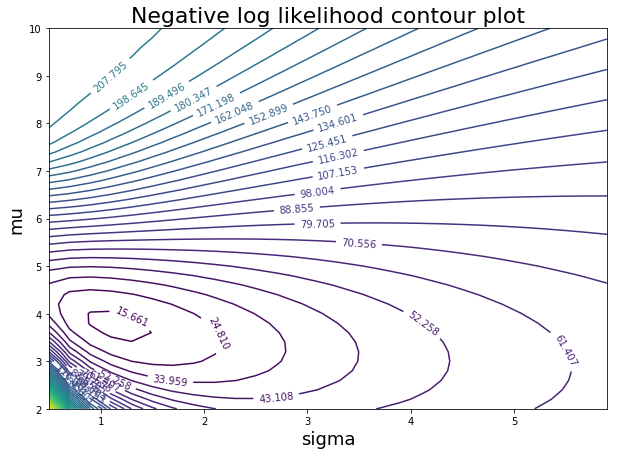

In [247]:
# Plot the contour
plt.figure(figsize=(10,7))
CS = plt.contour(S, M, L, levels=np.linspace(lmin+2, lmax, 50))
plt.clabel(CS, inline=1, fontsize=10)
plt.title('Negative log likelihood contour plot', fontsize=22)
plt.ylabel('mu', fontsize=18)
plt.xlabel('sigma', fontsize=18)
plt.show()

it appears that the best fit is located at $\mu=3.8$, $\sigma=1.2$.

## (c)

In [204]:
# We don't have fminsearch in Python so let's use
# scipy's fmin
from scipy.optimize import fmin

mu_min, sigma_min = fmin(
    lambda x: nloglik(x[0], x[1], I, T, C), 
    [2,2]
)
print('mu: %0.2f, sigma: %0.2f' % (mu_min, sigma_min))

Optimization terminated successfully.
         Current function value: 15.250873
         Iterations: 44
         Function evaluations: 82
mu: 4.06, sigma: 0.94


## (d)

In [232]:
from scipy.optimize import minimize

# Try a bunch of random starting points until we get a success
for i in range(10):
    start = np.random.multivariate_normal(mean=[2,2], cov=np.diag([2,2]))
    result = minimize(
        lambda x: nloglik(x[0], x[1], I, T, C), 
        start
    )
    if not np.isnan(result.fun):
        print('success!')
        break

success!


In [241]:
result.x

array([ 4.0629213,  0.9410956])

In [235]:
result.hess_inv

array([[ 0.02229787, -0.01033768],
       [-0.01033768,  0.02060021]])

In [243]:
std1 = np.sqrt(result.hess_inv[0,0])
std2 = np.sqrt(result.hess_inv[1,1])
print('95%% CI for mu: [%0.2f, %0.2f]' % (result.x[0] - 1.96*std1, result.x[0] + 1.96*std1))
print('95%% CI for sigma: [%0.2f, %0.2f]' % (result.x[1] - 1.96*std2, result.x[1] + 1.96*std2))

95% CI for mu: [3.77, 4.36]
95% CI for sigma: [0.66, 1.22]


Yes, the true parameter values (4 and 1) fall within the confidence intervals.

## (e)

In [249]:
def resample_data(I, C):
    """
    A function to resample the data using bootstrapping.
    """
    C_new = []
    for i, c in zip(I, C):
        # make a vector of the trials
        samples = np.zeros(100)
        samples[:c] = 1
        # draw a bootstrapped sample from this vector
        new_samples = np.random.choice(samples, 100, replace=True)
        # count the number of successes, store
        C_new.append(np.sum(new_samples))
    
    return np.asarray(C_new)

In [250]:
# run through the 500 trials, resampling the data
# each time and computing the optimal mu, sigma combo
mus = np.zeros(500)
sigmas = np.zeros(500)
for j in range(500):
    C_new = resample_data(I, C)
    mu_min, sigma_min = fmin(
        lambda x: nloglik(x[0], x[1], I, T, C_new), 
        [2,2],
        disp=0
    )
    mus[j] = mu_min
    sigmas[j] = sigma_min

/Users/reubenfeinman/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log
  if sys.path[0] == '':


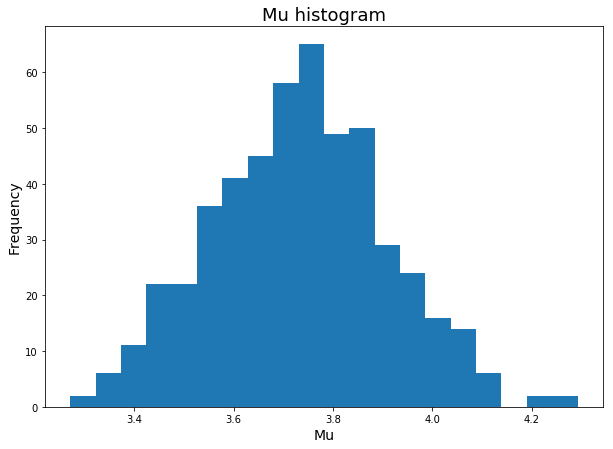

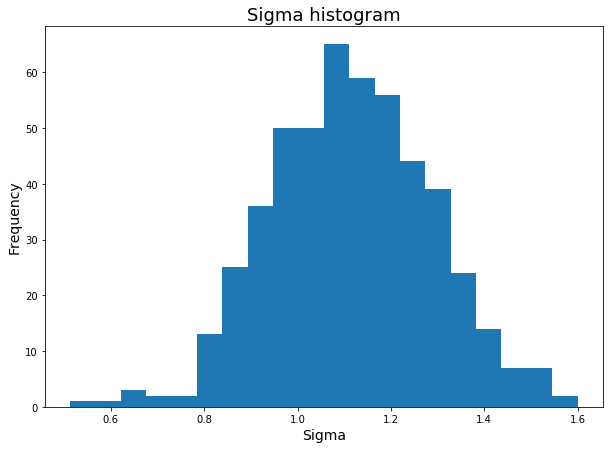

In [251]:
# plot mu histogram
plt.figure(figsize=(10,7))
plt.hist(mus, bins=20)
plt.title('Mu histogram', fontsize=18)
plt.xlabel('Mu', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.show()

# plot sigma histogram
plt.figure(figsize=(10,7))
plt.hist(sigmas, bins=20)
plt.title('Sigma histogram', fontsize=18)
plt.xlabel('Sigma', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.show()

In [255]:
vals, bins = np.histogram(sigmas, bins=100)

In [260]:
def compute_CI(data, nb_bins):
    size = len(data)
    vals, bins = np.histogram(data, bins=nb_bins)
    cs = np.cumsum(vals)
    i_bottom = np.where(cs/size >= 0.025)[0][0]
    i_top = np.where(cs/size >= 0.975)[0][0]
    
    return bins[i_bottom], bins[i_top]

In [261]:
# compute CI for sigma
bottom, top = compute_CI(sigmas, nb_bins=100)
print('2.5-97.5 CI for sigma: [%0.2f, %0.2f]' % (bottom, top))

2.5-97.5 CI for sigma: [0.78, 1.45]


In [262]:
# compute CI for mu
bottom, top = compute_CI(mus, nb_bins=100)
print('2.5-97.5 CI for mu: [%0.2f, %0.2f]' % (bottom, top))

2.5-97.5 CI for mu: [3.40, 4.07]


These values seem to agree very well with the 2D contour plot that we computed in (b) above.

# Problem #4

## (a)

Assume that our two data distributions are each 2D Gaussians described as $p_1(\vec{x}) = \mathcal{N}(\vec{x}; \vec{\mu_1}, \sigma^2I)$ and $p_2(\vec{x}) = \mathcal{N}(\vec{x}; \vec{\mu_2}, \sigma^2I)$. If we project the data onto the difference-of-means vector, we will then have two 1D Gaussians of the form $p_1(x) = \mathcal{N}(x; \mu_1, \sigma^2)$ and $p_2(x) = \mathcal{N}(x; \mu_2, \sigma^2)$ for some mean values $\{\mu_1, \mu_2\}$. Assume, without loss of generality, that $\mu_2 > \mu_1$ and that we would like to build a binary classifier that detects class 2. Our goal here is to prove that the classifier $f(x) = 1_{\{x > \frac{\mu_2 - \mu_1}{2}\}}$ is the maximum likelihood classifier. In other words, we want to prove that $x > \frac{\mu_2 - \mu_1}{2}$ implies $p_2(x) > p_1(x)$. Let's step through the proof:

$p_2(x) > p_1(x)$

iff $\frac{1}{\sqrt{2\pi}\sigma} e^-{\frac{(x - \mu_2)^2}{2\sigma^2}} > \frac{1}{\sqrt{2\pi}\sigma} e^-{\frac{(x - \mu_1)^2}{2\sigma^2}}$

iff $-\frac{(x - \mu_2)^2}{2\sigma^2} > -\frac{(x - \mu_1)^2}{2\sigma^2}$

iff $|x - \mu_2| < |x - \mu_1|$.

So we need to show that $x > \frac{\mu_2 - \mu_1}{2}$ implies $|x - \mu_2| < |x - \mu_1|$. This is easy to show. Since $\frac{\mu_2 - \mu_1}{2}$ is the halfway point between $\mu_1$ and $\mu_2$, and we know $\mu_2 > \mu_1$, then if $x$ is greater than the halfway point it will be closer to $\mu_2$ than $\mu_1$.

In [558]:
# First, load the data
import scipy.io as sio

data1 = sio.loadmat('fisherData.mat')['data1']
data2 = sio.loadmat('fisherData.mat')['data2']

In [559]:
print(data1.shape)
print(data2.shape)

(70, 2)
(70, 2)


In [560]:
# Collect the means
mu1 = np.mean(data1, axis=0)
mu2 = np.mean(data2, axis=0)

In [563]:
# Build the meshgrid
vmin = min(np.min(data1), np.min(data2)) - 1
vmax = max(np.max(data1), np.max(data2)) + 1

x = np.linspace(vmin, vmax, 200)
y = np.linspace(vmin, vmax, 200)
X, Y = np.meshgrid(x, y)

In [564]:
from scipy.stats import multivariate_normal as mvn

# helper function for computing the 2 gaussian images
def compute_gauss_image(X, Y, mu):
    x_len = X.shape[1]
    y_len = X.shape[0]
    G = np.zeros_like(X)
    for y in range(y_len):
        for x in range(x_len):
            # Get PDF value of the 2D gaussian at this location
            # (identity covariance)
            G[y,x] = mvn.pdf([X[y_len-y-1,x], Y[y_len-y-1,x]], mean=mu, cov=1)
            
    return G

In [565]:
# Compute the 2 Gaussian images
G1 = compute_gauss_image(X, Y, mu1)
G2 = compute_gauss_image(X, Y, mu2)
# Compute the binary image
bin_image = G2 > G1

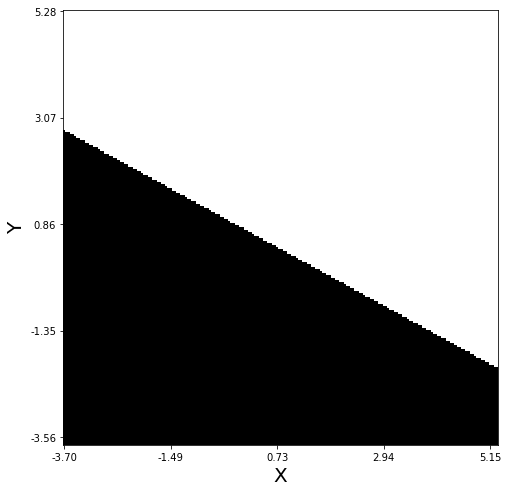

In [570]:
# Show the binary image
ticks = np.asarray(range(0, 200, 49))
xticks = ['%0.2f' % val for val in x[ticks]]
yticks = ['%0.2f' % val for val in y[200-ticks-1]]
plt.figure(figsize=(8,8))
plt.imshow(bin_image, cmap='gray')
plt.xlabel('X', fontsize=20)
plt.ylabel('Y', fontsize=20)
plt.xticks(ticks, xticks)
plt.yticks(ticks, yticks)
plt.show()

Here, the white corresponds to all of the locations where we'd classify as type 2 (from data2 distribution), and the black to locations for type 1. I don't know how to plot the data points on top of an image in Python (it seems very complicated), so I'm going to show the data points in the next plot.

In [674]:
# Compute the normalized difference-of-means vector
diff = mu2 - mu1
diff /= np.linalg.norm(diff)

I don't know how to plot a vector on top of an image in Python. I'm going to plot the difference vector, along with the data points, on a separate plot that is scaled exactly the same.

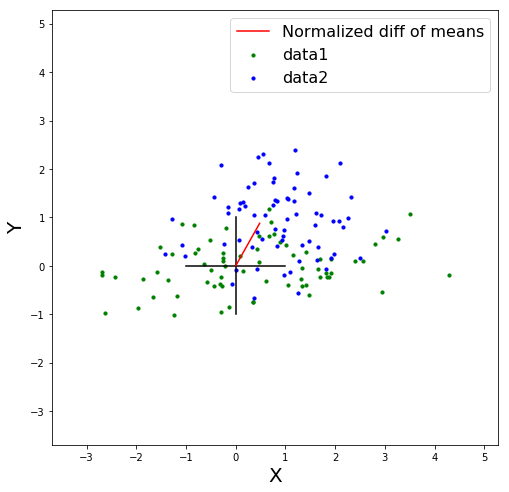

In [701]:
plt.figure(figsize=(8,8))
# First, plot the axes
plt.plot([-1, 1], [0, 0], c='black')
plt.plot([0, 0], [-1, 1], c='black')
# Now, plot the difference vector
plt.plot([0, diff[0]], [0, diff[1]], label='Normalized diff of means', color='r')
# Now, plot the data points
plt.scatter(data1[:,0], data1[:,1], label='data1', color='g', s=10)
plt.scatter(data2[:,0], data2[:,1], label='data2', color='b', s=10)
plt.legend(fontsize=16)
plt.xlim(vmin, vmax)
plt.ylim(vmin, vmax)
plt.xlabel('X', fontsize=20)
plt.ylabel('Y', fontsize=20)
plt.show()

As we can see, the difference of means vector (red line in this plot) is parallel to the decision boundary (black/white boundary in above plot). Let's see how many points are correctly classified...

In [693]:
# Transform means to new space
mu1_proj = np.matmul(diff, mu1)
mu2_proj = np.matmul(diff, mu2)
# Transform data points to new space
d1_proj = np.matmul(diff, data1.T)
d2_proj = np.matmul(diff, data2.T)
# Get predictions
d1_preds = [np.abs(val-mu2_proj) < np.abs(val-mu1_proj) for val in d1_proj]
d2_preds = [np.abs(val-mu2_proj) < np.abs(val-mu1_proj) for val in d2_proj]
# Compute accuracy
nb_correct = np.where(d2_preds)[0].shape[0] + (data1.shape[0] - np.where(d1_preds)[0].shape[0])
accuracy = nb_correct / (data1.shape[0] + data2.shape[0])
print('Fraction of points correctly classified: %0.3f' % accuracy)

Fraction of points correctly classified: 0.736


## (b)

In [654]:
# First, compute the covariance matrices for each class
d1 = data1 - data1.mean(axis=0)
cov1 = np.matmul(np.transpose(d1), d1)/ data1.shape[0]
d2 = data2 - data2.mean(axis=0)
cov2 = np.matmul(np.transpose(d2), d2)/ data2.shape[0]

In [661]:
# Now, estimate the common covariance
cov = cov1 + cov2

In [736]:
import scipy.linalg as la

# Compute the eigenvalue decomposition of the common covariance
eigvals, V = la.eig(cov)
# la.eig returns complex numbers as eigenvalues, but
# we know that ours do not have any complex part, so we
# can take abs to convert to real
eigvals = np.abs(eigvals)
# Compute D^-1
D_inv = np.diag(1/np.sqrt(eigvals))

In [739]:
# From lecture we know how to compute the optimal discriminant
# vector... w = D_inv*V^T*(mu_2 - mu_1)
w_opt = np.matmul(D_inv, np.matmul(V.T, mu2 - mu1))
# normalize it
w_opt /= np.linalg.norm(w_opt)

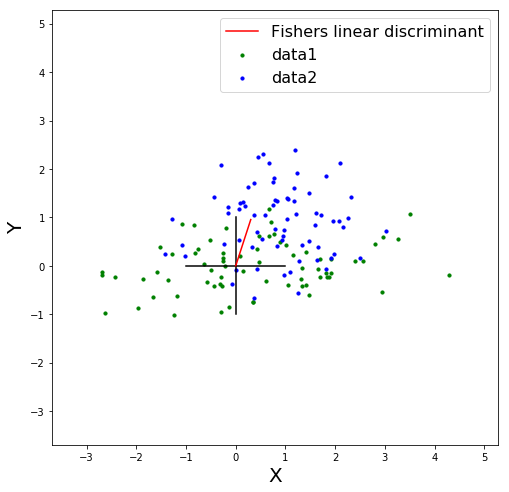

In [741]:
# Now let's plot the discriminant and the data
plt.figure(figsize=(8,8))
# First, plot the axes
plt.plot([-1, 1], [0, 0], c='black')
plt.plot([0, 0], [-1, 1], c='black')
# Now, plot the difference vector
plt.plot([0, w_opt[0]], [0, w_opt[1]], label='Fishers linear discriminant', color='r')
# Now, plot the data points
plt.scatter(data1[:,0], data1[:,1], label='data1', color='g', s=10)
plt.scatter(data2[:,0], data2[:,1], label='data2', color='b', s=10)
plt.legend(fontsize=16)
plt.xlim(vmin, vmax)
plt.ylim(vmin, vmax)
plt.xlabel('X', fontsize=20)
plt.ylabel('Y', fontsize=20)
plt.show()

Let's now see how many of the points are correctly classified by this classifier:

In [742]:
# Transform means to new space
mu1_proj = np.matmul(w_opt, mu1)
mu2_proj = np.matmul(w_opt, mu2)
# Transform data points to new space
d1_proj = np.matmul(w_opt, data1.T)
d2_proj = np.matmul(w_opt, data2.T)
# Get predictions
d1_preds = [np.abs(val-mu2_proj) < np.abs(val-mu1_proj) for val in d1_proj]
d2_preds = [np.abs(val-mu2_proj) < np.abs(val-mu1_proj) for val in d2_proj]
# Compute accuracy
nb_correct = np.where(d2_preds)[0].shape[0] + (data1.shape[0] - np.where(d1_preds)[0].shape[0])
accuracy = nb_correct / (data1.shape[0] + data2.shape[0])
print('Fraction of points correctly classified: %0.3f' % accuracy)

Fraction of points correctly classified: 0.750


We can see that our classification accuracy improved from 73.6% in (a) to 75.0% in (b).

## (c)

We have already estimated the mean and covariances of our data (stored as {mu1, cov1} and {mu2, cov2}, so we can go ahead with the probability calculations. The probability of a point $\vec{x}$ under a multivariate normal $\mathcal{N}(\vec{\mu}, \Sigma)$ is equal to

$p(\vec{x}) = 
(\frac{1}{2\pi})^{p/2} |\Sigma|^{-1/2} 
e^{-\frac{1}{2}(\vec{x}-\vec{\mu})\Sigma^{-1}(\vec{x}-\vec{\mu})^T}$.

Let's write a function to compute this probability:

In [771]:
# Write a function to compute the likelihood.
def multivariate_normal(x, mu, cov):
    size = len(x)
    assert size == len(mu) # sanity check
    assert cov.shape == (size, size) # sanity check
    # compute determinant
    det = la.det(cov)
    assert not det == 0 # sanity check; cov can't be singular
    # compute the normalizing constant
    norm = 1/(np.power(2*np.pi, 0.5*size)*np.power(det, 0.5))
    # compute the exponent
    x_mu = np.array(x - mu)
    exponent = -0.5*np.matmul(x_mu, np.matmul(la.inv(cov), x_mu.T))
    
    # return norm*e^(exponent)
    return norm*np.exp(exponent)

In [778]:
# Let's plot another binary image as we did in part (a).
# Here's a helper function for computing the 2 gaussian images
def compute_gauss_image(X, Y, mu, cov):
    x_len = X.shape[1]
    y_len = X.shape[0]
    G = np.zeros_like(X)
    for y in range(y_len):
        for x in range(x_len):
            # Call our function multivariate normal to get prob
            G[y,x] = multivariate_normal(
                [X[y_len-y-1,x], Y[y_len-y-1,x]],
                mu,
                cov
            )
            
    return G

In [782]:
# Build the meshgrid
vmin = min(np.min(data1), np.min(data2)) - 1
vmax = max(np.max(data1), np.max(data2)) + 1

x = np.linspace(vmin, vmax, 200)
y = np.linspace(vmin, vmax, 200)
X, Y = np.meshgrid(x, y)

# Compute the 2 Gaussian images
G1 = compute_gauss_image(X, Y, mu1, cov1)
G2 = compute_gauss_image(X, Y, mu2, cov2)
# Compute the binary image
bin_image = G2 > G1

Again, as in (a), can't plot binary image and points on same plot so I will use 2 separate plots.

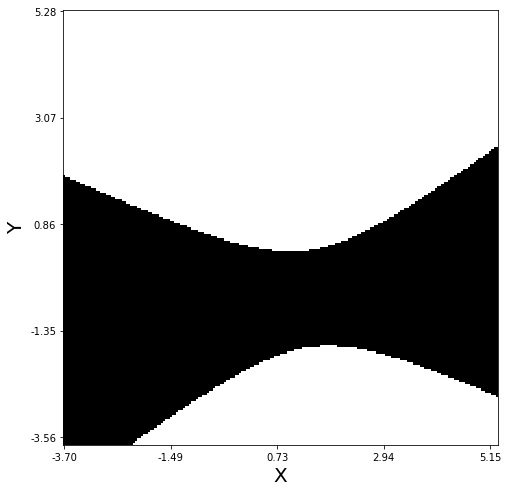

In [783]:
# Show the binary image
ticks = np.asarray(range(0, 200, 49))
xticks = ['%0.2f' % val for val in x[ticks]]
yticks = ['%0.2f' % val for val in y[200-ticks-1]]
plt.figure(figsize=(8,8))
plt.imshow(bin_image, cmap='gray')
plt.xlabel('X', fontsize=20)
plt.ylabel('Y', fontsize=20)
plt.xticks(ticks, xticks)
plt.yticks(ticks, yticks)
plt.show()

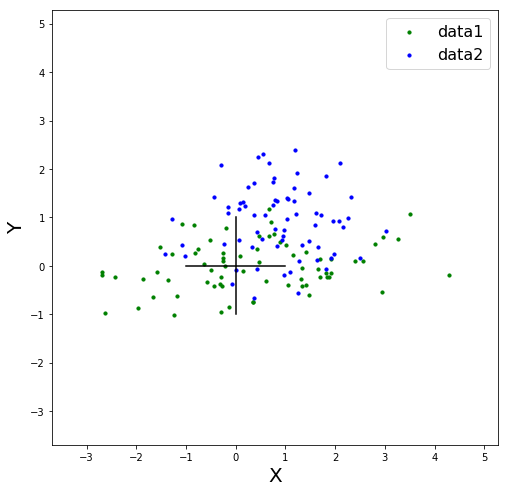

In [784]:
# Now let's plot the data points
plt.figure(figsize=(8,8))
# First, plot the axes
plt.plot([-1, 1], [0, 0], c='black')
plt.plot([0, 0], [-1, 1], c='black')
# Now, plot the data points
plt.scatter(data1[:,0], data1[:,1], label='data1', color='g', s=10)
plt.scatter(data2[:,0], data2[:,1], label='data2', color='b', s=10)
plt.legend(fontsize=16)
plt.xlim(vmin, vmax)
plt.ylim(vmin, vmax)
plt.xlabel('X', fontsize=20)
plt.ylabel('Y', fontsize=20)
plt.show()

In [785]:
# Write a function to get the prediction for a point x.
# Prediction = True if we think this is class 2, False
# otherwise.
def predict(x, mu1, mu2, cov1, cov2):
    p1 = multivariate_normal(x, mu1, cov1)
    p2 = multivariate_normal(x, mu2, cov2)
    return p2 > p1

In [786]:
# Get predictions
d1_preds = [predict(x, mu1, mu2, cov1, cov2) for x in data1]
d2_preds = [predict(x, mu1, mu2, cov1, cov2) for x in data2]
# Compute accuracy
nb_correct = np.where(d2_preds)[0].shape[0] + (data1.shape[0] - np.where(d1_preds)[0].shape[0])
accuracy = nb_correct / (data1.shape[0] + data2.shape[0])
print('Fraction of points correctly classified: %0.3f' % accuracy)

Fraction of points correctly classified: 0.800


We can see that our classification accuracy improved from 75.0% in (a) to 80.0% in (b). So the quadratic classifier is the best. I think that this would always be the best because the other two classifiers have simplifying assumptions (diff-of-means assumes independent variables, Fisher's assumes that the covariance matrices of each class are roughly equal). I don't see a case where this could be worse... unless the data is very non-Gaussian (in which case it does't make much sense to assume Gaussian blobs).